<a href="https://colab.research.google.com/github/mc-ivan/zero-shot/blob/main/lab4/notebooks/Practica4_Grupo3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 4: Modelado Generativo de Espacios Habitacionales

**CASO: VAE usando LSUN Bedrooms**

**Grupo 3**
- Ivan Mamani
- Yesica Luna
- Elvis Miranda

**Dataset:** https://www.kaggle.com/datasets/jhoward/lsun_bedroom?resource=download

---

In [1]:
# INSTALACIÓN DE LIBRERÍAS
# Instalamos librerías necesarias para acceder a Kaggle y manejar Deep Learning
!pip install kagglehub tensorflow matplotlib


In [2]:
# AUTENTICACIÓN KAGGLE
# Importamos librería para manejar variables de entorno
import os

# Pegamos aquí el TOKEN generado en Kaggle
# Esto permite que Colab tenga acceso autenticado al dataset
os.environ['KAGGLE_API_TOKEN'] = 'KGAT_47d68c937927872776f74bfa08c0a0a7'


In [3]:
# DESCARGA DEL DATASET
import kagglehub

# Descargamos el dataset directamente desde Kaggle
path = kagglehub.dataset_download("jhoward/lsun_bedroom")

# Mostramos la ruta donde se almacenó
print("\nDataset descargado en:", path)


Using Colab cache for faster access to the 'lsun_bedroom' dataset.

Dataset descargado en: /kaggle/input/lsun_bedroom


In [4]:
# DEFINIR CARPETA DATASET

DATA_FOLDER = path + "/data0/lsun"

print("Dataset listo en:", DATA_FOLDER)


Dataset listo en: /kaggle/input/lsun_bedroom/data0/lsun


In [5]:
# CONTEO DE IMÁGENES (Verificar cantidad de imágenes)

import numpy as np
from glob import glob

# Buscamos todas las imágenes JPG dentro del dataset
filenames = np.array(glob(os.path.join(DATA_FOLDER, '**/*.jpg'), recursive=True))

# Contamos cuántas imágenes existen
NUM_IMAGES = len(filenames)

print("Cantidad de imágenes:", NUM_IMAGES)


Cantidad de imágenes: 303125


In [6]:
# PARÁMETROS DEL MODELO VAE

INPUT_DIM = (64, 64, 3)   # Dimensión de imágenes
BATCH_SIZE = 512          # Tamaño del lote
Z_DIM = 200               # Dimensión del espacio latente
LEARNING_RATE = 0.0005    # Tasa de aprendizaje
N_EPOCHS = 10              # Número de épocas
LOSS_FACTOR = 10000       # Factor de reconstrucción


In [7]:
# GENERADOR DE IMAGENES (DATOS)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(
    DATA_FOLDER,
    target_size=INPUT_DIM[:2],
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='input'
)


Found 303125 images belonging to 1 classes.


In [8]:
# CONSTRUCCIÓN DEL ENCODER

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def build_encoder(input_dim, latent_dim):

    encoder_input = Input(shape=input_dim)

    x = Conv2D(32, 3, strides=2, padding='same')(encoder_input)
    x = LeakyReLU()(x)

    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    shape_before_flattening = K.int_shape(x)[1:]

    x = Flatten()(x)

    mean_mu = Dense(latent_dim)(x)
    log_var = Dense(latent_dim)(x)

    # Reparametrización
    def sampling(args):
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu))
        return mu + K.exp(log_var / 2) * epsilon

    encoder_output = Lambda(sampling)([mean_mu, log_var])

    encoder = Model(encoder_input, [encoder_output, mean_mu, log_var])

    return encoder, shape_before_flattening

encoder, shape_before_flattening = build_encoder(INPUT_DIM, Z_DIM)
encoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 64)  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │    819,400 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │    819,400 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 200)       │          0 │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,695,120 (6.47 MB)

 Trainable params: 1,695,120 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# CONSTRUCCIÓN DEL DECODER

from tensorflow.keras.layers import Conv2DTranspose, Reshape

def build_decoder(latent_dim, shape_before_flattening):

    decoder_input = Input(shape=(latent_dim,))

    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    decoder_output = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(decoder_input, decoder_output)

    return decoder

decoder = build_decoder(Z_DIM, shape_before_flattening)
decoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │       823,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 916,483 (3.50 MB)

 Trainable params: 916,483 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# CAPA KL LOSS (OBLIGATORIA en Keras 3)

from tensorflow.keras.layers import Layer
import tensorflow as tf

class KLDivergenceLayer(Layer):
    def call(self, inputs):
        mean_mu, log_var = inputs

        kl_loss = -0.5 * tf.reduce_sum(
            1 + log_var - tf.square(mean_mu) - tf.exp(log_var),
            axis=1
        )

        # Se agrega automáticamente al modelo
        self.add_loss(tf.reduce_mean(kl_loss) / (64*64))

        return inputs


In [11]:
# CONSTRUCCIÓN DEL VAE

vae_input = encoder.input
encoder_output, mean_mu, log_var = encoder(vae_input)

# Integramos KL dentro del grafo
mean_mu, log_var = KLDivergenceLayer()([mean_mu, log_var])

vae_output = decoder(encoder_output)

vae = tf.keras.models.Model(vae_input, vae_output)


In [12]:
# KL LOSS integrado correctamente dentro del grafo

from tensorflow.keras.layers import Layer

class KLDivergenceLayer(Layer):
    def call(self, inputs):
        mean_mu, log_var = inputs

        kl_loss = -0.5 * tf.reduce_sum(
            1 + log_var - tf.square(mean_mu) - tf.exp(log_var),
            axis=1
        )

        # Se agrega automáticamente al modelo
        self.add_loss(tf.reduce_mean(kl_loss) / (64*64))

        return inputs


In [13]:
# COMPILAR MODELO

def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred), axis=[1,2,3])

from tensorflow.keras.optimizers import Adam

optimizer = Adam(LEARNING_RATE)

vae.compile(
    optimizer=optimizer,
    loss=reconstruction_loss
)


In [14]:
# ENTRENAMIENTO DEL MODELO

steps_per_epoch = NUM_IMAGES // BATCH_SIZE

vae.fit(
    data_flow,
    steps_per_epoch=steps_per_epoch,
    epochs=N_EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 1928s 3s/step - loss: 0.0397
Epoch 2/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 3s 35us/step - loss: 0.0164 
Epoch 3/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


592/592 ━━━━━━━━━━━━━━━━━━━━ 408s 689ms/step - loss: 0.0150
Epoch 4/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 31us/step - loss: 0.0138   
Epoch 5/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 410s 692ms/step - loss: 0.0135
Epoch 6/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 35us/step - loss: 0.0128   
Epoch 7/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 403s 680ms/step - loss: 0.0128
Epoch 8/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 31us/step - loss: 0.0123   
Epoch 9/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 403s 680ms/step - loss: 0.0124
Epoch 10/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 32us/step - loss: 0.0122   


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


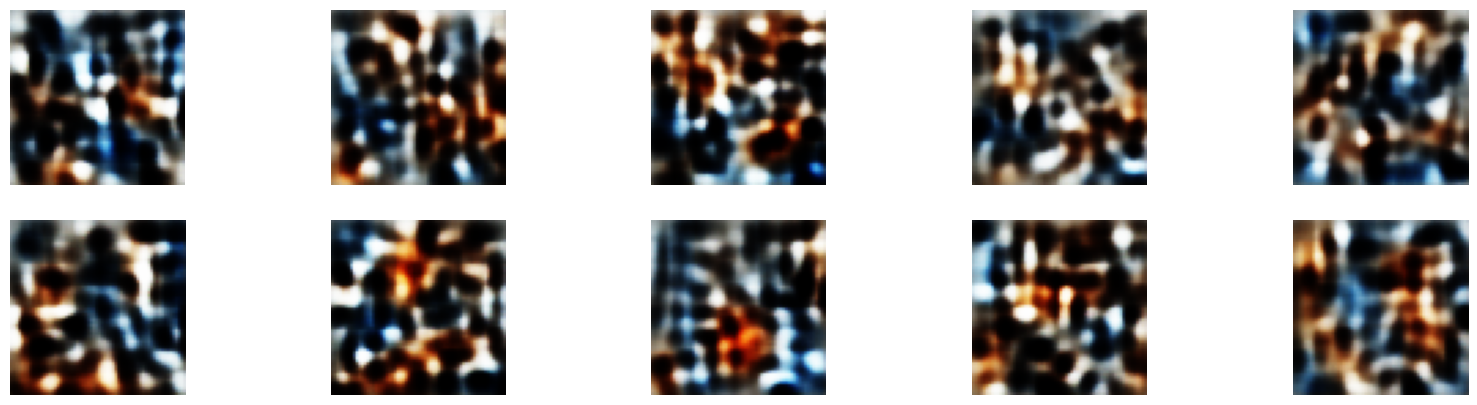

In [15]:
# GENERACIÓN DE IMÁGENES

import matplotlib.pyplot as plt

def generar_imagenes(n=10):

    # Generamos ruido en espacio latente
    z = np.random.normal(size=(n, Z_DIM))

    # Generamos imágenes
    imgs = decoder.predict(z)

    plt.figure(figsize=(20,5))

    for i in range(n):
        plt.subplot(2, n//2, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

    plt.show()

generar_imagenes(10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


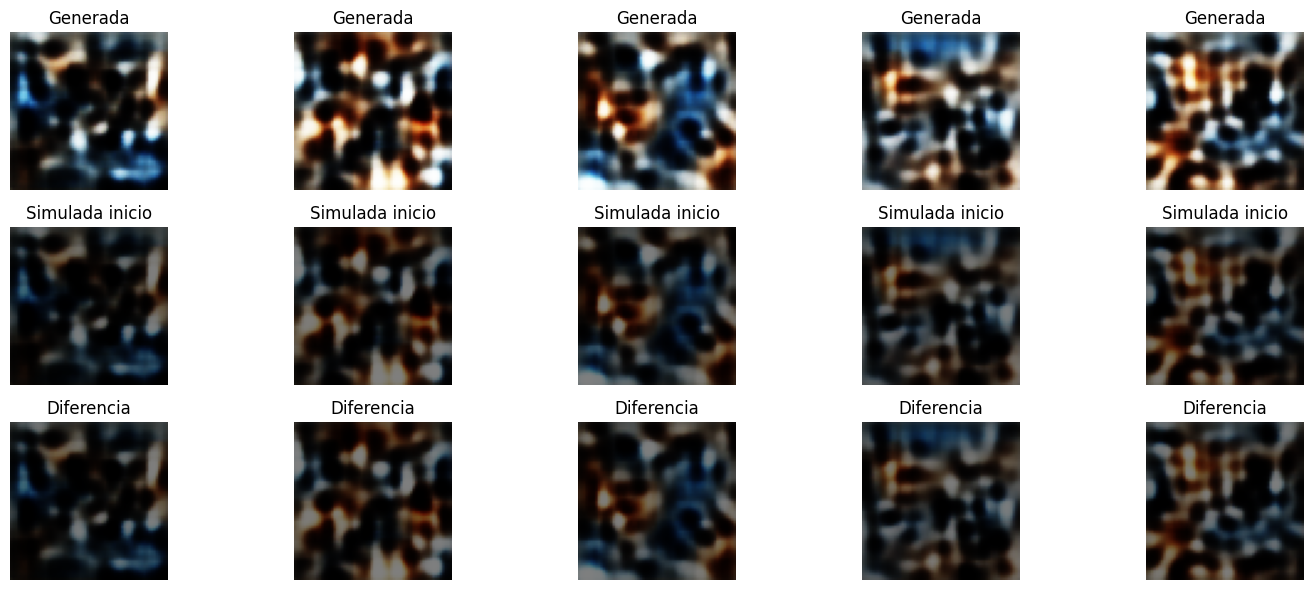

In [17]:
# COMPARACIÓN VISUAL CON DIFERENCIA

import numpy as np
import matplotlib.pyplot as plt

z = np.random.normal(size=(5, Z_DIM))

imgs = decoder.predict(z)

plt.figure(figsize=(15,6))

for i in range(5):

    # Imagen original generada
    plt.subplot(3,5,i+1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title("Generada")

    # Imagen suavizada (simula etapa temprana)
    blur = imgs[i] * 0.5
    plt.subplot(3,5,i+6)
    plt.imshow(blur)
    plt.axis("off")
    plt.title("Simulada inicio")

    # Diferencia absoluta
    diff = np.abs(imgs[i] - blur)
    plt.subplot(3,5,i+11)
    plt.imshow(diff)
    plt.axis("off")
    plt.title("Diferencia")

plt.tight_layout()
plt.show()
